In [322]:
# ============================================================================
# IMPORTS - TOUTES LES BIBLIOTHÈQUES NÉCESSAIRES
# ============================================================================

# Manipulation de données
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Preprocessing
import sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Modèles de Machine Learning - Classiques
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# XGBoost et LightGBM
import xgboost as xgb
from xgboost import XGBRegressor
try:
    import lightgbm as lgb
    from lightgbm import LGBMRegressor
except ImportError:
    print("⚠️ LightGBM non installé. Pour l'installer: pip install lightgbm")

# CatBoost
try:
    from catboost import CatBoostRegressor
except ImportError:
    print("⚠️ CatBoost non installé. Pour l'installer: pip install catboost")

# Réseaux de neurones - TensorFlow/Keras
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Conv1D, MaxPooling1D, Flatten
    from tensorflow.keras.layers import BatchNormalization, Activation, Input, Concatenate
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    from tensorflow.keras.optimizers import Adam, RMSprop, SGD
except ImportError:
    print("⚠️ TensorFlow non installé. Pour l'installer: pip install tensorflow")

# Réseaux de neurones - PyTorch (alternative)
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader, TensorDataset
except ImportError:
    print("⚠️ PyTorch non installé. Pour l'installer: pip install torch")

# Modèles de séries temporelles
try:
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.tsa.stattools import adfuller, acf, pacf
except ImportError:
    print("⚠️ Statsmodels non installé. Pour l'installer: pip install statsmodels")

# pmdarima (peut avoir des problèmes de compatibilité avec certaines versions de numpy)
try:
    from pmdarima import auto_arima
except (ImportError, ValueError) as e:
    print(f"⚠️ pmdarima non disponible: {type(e).__name__}")
    print("   → Si besoin, réinstaller: pip uninstall pmdarima -y && pip install pmdarima")

# Prophet (Facebook)
try:
    from prophet import Prophet
except ImportError:
    print("⚠️ Prophet non installé. Pour l'installer: pip install prophet")

# Suppression des warnings
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("✅ BIBLIOTHÈQUES CHARGÉES")
print("=" * 80)
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")
print(f"🤖 Scikit-learn version: {sklearn.__version__}")
print(f"🚀 XGBoost version: {xgb.__version__}")
try:
    print(f"💡 LightGBM version: {lgb.__version__}")
except:
    pass
try:
    print(f"🧠 TensorFlow version: {tf.__version__}")
except:
    pass
try:
    print(f"🔥 PyTorch version: {torch.__version__}")
except:
    pass
print("=" * 80)

⚠️ pmdarima non disponible: ValueError
   → Si besoin, réinstaller: pip uninstall pmdarima -y && pip install pmdarima
✅ BIBLIOTHÈQUES CHARGÉES
📊 Pandas version: 2.2.3
🔢 NumPy version: 2.1.3
🤖 Scikit-learn version: 1.6.1
🚀 XGBoost version: 3.1.1
💡 LightGBM version: 4.6.0
🧠 TensorFlow version: 2.19.0
🔥 PyTorch version: 2.6.0


In [323]:
# ============================================================================
# CHARGEMENT DES DONNÉES
# ============================================================================

print("📂 Chargement des fichiers...")

# Charger les données de trafic principales
df_model = pd.read_csv('0.dataset_raw/champs_elysees.csv', sep=';')
print(f"✅ Données de trafic chargées: {df_model.shape}")

# Afficher les premières lignes
print("\n📋 Aperçu des données:")
print(df_model.head())

print("\n📊 Info sur les colonnes:")
print(df_model.info())

📂 Chargement des fichiers...
✅ Données de trafic chargées: (9266, 15)

📋 Aperçu des données:
   Identifiant arc            Libelle  Date et heure de comptage  \
0             4264  AV_Champs_Elysees  2024-12-09T05:00:00+01:00   
1             4264  AV_Champs_Elysees  2024-12-09T06:00:00+01:00   
2             4264  AV_Champs_Elysees  2024-12-09T09:00:00+01:00   
3             4264  AV_Champs_Elysees  2025-09-02T09:00:00+02:00   
4             4264  AV_Champs_Elysees  2024-09-04T20:00:00+02:00   

   Débit horaire  Taux d'occupation Etat trafic  Identifiant noeud amont  \
0          199.0            2.20945      Fluide                     2294   
1          235.0            2.28778      Fluide                     2294   
2         1041.0           11.63222      Fluide                     2294   
3         1139.0           28.39222  Pré-saturé                     2294   
4          686.0           13.21611      Fluide                     2294   

            Libelle noeud amont  Identifi

In [324]:
# ============================================================================
# RENOMMAGE DES COLONNES - Nettoyage et standardisation
# ============================================================================

print("🔧 Renommage des colonnes...")

# Fonction de nettoyage des noms de colonnes
def nettoyer_nom_colonne(nom):
    """Nettoie le nom de colonne: supprime espaces, accents, apostrophes"""
    import unicodedata
    # Supprimer les accents
    nom = unicodedata.normalize('NFD', nom)
    nom = nom.encode('ascii', 'ignore').decode('utf-8')
    # Remplacer espaces par underscore, supprimer apostrophes
    nom = nom.replace(' ', '_').replace("'", '').replace('-', '_')
    # Mettre en minuscules
    nom = nom.lower()
    return nom

# Afficher les colonnes AVANT renommage
print("\n📋 Colonnes AVANT renommage:")
for i, col in enumerate(df_model.columns[:10], 1):
    print(f"  {i}. {col}")
if len(df_model.columns) > 10:
    print(f"  ... ({len(df_model.columns)} colonnes au total)")

# Renommer toutes les colonnes
df_model.columns = [nettoyer_nom_colonne(col) for col in df_model.columns]

print("\n✅ Colonnes APRÈS renommage:")
for i, col in enumerate(df_model.columns[:15], 1):
    print(f"  {i}. {col}")
if len(df_model.columns) > 15:
    print(f"  ... ({len(df_model.columns)} colonnes au total)")
# Afficher les types de données
print(f"\n📊 Shape: {df_model.shape}")
print(f"📊 Types de données:")
print(df_model.dtypes)

🔧 Renommage des colonnes...

📋 Colonnes AVANT renommage:
  1. Identifiant arc
  2. Libelle
  3. Date et heure de comptage
  4. Débit horaire
  5. Taux d'occupation
  6. Etat trafic
  7. Identifiant noeud amont
  8. Libelle noeud amont
  9. Identifiant noeud aval
  10. Libelle noeud aval
  ... (15 colonnes au total)

✅ Colonnes APRÈS renommage:
  1. identifiant_arc
  2. libelle
  3. date_et_heure_de_comptage
  4. debit_horaire
  5. taux_doccupation
  6. etat_trafic
  7. identifiant_noeud_amont
  8. libelle_noeud_amont
  9. identifiant_noeud_aval
  10. libelle_noeud_aval
  11. etat_arc
  12. date_debut_dispo_data
  13. date_fin_dispo_data
  14. geo_point_2d
  15. geo_shape

📊 Shape: (9266, 15)
📊 Types de données:
identifiant_arc                int64
libelle                       object
date_et_heure_de_comptage     object
debit_horaire                float64
taux_doccupation             float64
etat_trafic                   object
identifiant_noeud_amont        int64
libelle_noeud_amont 

In [325]:
# ============================================================================
# SUPPRESSION DES COLONNES INUTILES & ANALYSE DES VALEURS MANQUANTES
# ============================================================================

print("🗑️  Suppression des colonnes inutiles...")

# Colonnes à supprimer (non pertinentes pour l'entraînement)
colonnes_a_supprimer = [
    'identifiant_noeud_amont',  # Identifiant technique
    'libelle_noeud_amont',      # Label technique
    'identifiant_noeud_aval',   # Identifiant technique
    'libelle_noeud_aval',       # Label technique
    'date_debut_dispo_data',    # Métadonnée
    'date_fin_dispo_data',      # Métadonnée
    'geo_point_2d',             # Géolocalisation
    'geo_shape',                # Géométrie
]

# Supprimer les colonnes
colonnes_supprimees = []
for col in colonnes_a_supprimer:
    if col in df_model.columns:
        df_model = df_model.drop(columns=[col])
        colonnes_supprimees.append(col)
        print(f"  ❌ {col}")

print(f"\n✅ {len(colonnes_supprimees)} colonnes supprimées")
print(f"📊 Shape après nettoyage: {df_model.shape}")

# Analyse des valeurs manquantes
print("\n" + "=" * 80)
print("VALEURS MANQUANTES PAR COLONNE")
print("=" * 80)
na_summary = pd.DataFrame({
    'colonne': df_model.columns,
    'nb_na': df_model.isna().sum().values,
    'pct_na': (df_model.isna().sum() / len(df_model) * 100).values
})
na_summary = na_summary[na_summary['nb_na'] > 0].sort_values('pct_na', ascending=False)

if len(na_summary) > 0:
    print(na_summary.to_string(index=False))
else:
    print("✅ Aucune valeur manquante!")

print(f"\n📋 Colonnes conservées ({len(df_model.columns)}):")
for col in df_model.columns:
    print(f"  ✓ {col}")

🗑️  Suppression des colonnes inutiles...
  ❌ identifiant_noeud_amont
  ❌ libelle_noeud_amont
  ❌ identifiant_noeud_aval
  ❌ libelle_noeud_aval
  ❌ date_debut_dispo_data
  ❌ date_fin_dispo_data
  ❌ geo_point_2d
  ❌ geo_shape

✅ 8 colonnes supprimées
📊 Shape après nettoyage: (9266, 7)

VALEURS MANQUANTES PAR COLONNE
         colonne  nb_na   pct_na
taux_doccupation    622 6.712713
   debit_horaire    563 6.075977

📋 Colonnes conservées (7):
  ✓ identifiant_arc
  ✓ libelle
  ✓ date_et_heure_de_comptage
  ✓ debit_horaire
  ✓ taux_doccupation
  ✓ etat_trafic
  ✓ etat_arc


In [327]:
# ============================================================================
# CONVERSION DATETIME & EXTRACTION DES FEATURES TEMPORELLES
# ============================================================================

print("📅 Conversion de la colonne date_et_heure_de_comptage...")

# ✅ SOLUTION : Supprimer le timezone du STRING avant conversion
# Cela évite tout décalage horaire
# Conversion en datetime en conservant le timezone


df_model['date_et_heure_de_comptage'] = pd.to_datetime(
   df_model['date_et_heure_de_comptage'].astype(str).str.replace(r'[+-]\d{2}:\d{2}$', '', regex=True),
   errors='coerce')
# df_model['date_et_heure_de_comptage'] = pd.to_datetime(
#     df_model['date_et_heure_de_comptage'].astype(str),
#     errors='coerce'
# )
# # Supprimer les lignes avec des dates invalides
# nb_avant = len(df_model)
# df_model = df_model.dropna(subset=['date_et_heure_de_comptage'])
# nb_apres = len(df_model)
# if nb_avant > nb_apres:
#     print(f"  ℹ️  {nb_avant - nb_apres} lignes supprimées (dates invalides)")

# Renommer en 'date_heure_comptage' pour simplifier
df_model = df_model.rename(columns={'date_et_heure_de_comptage': 'date_heure_comptage',
                                    'taux_doccupation':'taux_occupation'})
print(f"  ✓ Colonne renommée: 'date_et_heure_de_comptage' → 'date_heure_comptage'")


print(f"\n📊 Shape: {df_model.shape}")
print(f"📅 Période des données: {df_model['date_heure_comptage'].min()} → {df_model['date_heure_comptage'].max()}")
print(df_model['date_heure_comptage'].dtype)


📅 Conversion de la colonne date_et_heure_de_comptage...
  ✓ Colonne renommée: 'date_et_heure_de_comptage' → 'date_heure_comptage'

📊 Shape: (9266, 7)
📅 Période des données: 2024-09-01 05:00:00 → 2025-10-30 00:00:00
datetime64[ns]


In [328]:
# Vérifie si des doublons existent
df_model['date_heure_comptage'].duplicated().any()

np.False_

In [329]:
# Charger le fichier
vacances_df = pd.read_csv('1.dataset_trusted/vacances.csv', 
                          delimiter=';')
print(vacances_df.info())

# Sélectionner uniquement les colonnes utiles
vacances_df = vacances_df[['description', 'date_de_debut', 'date_de_fin']]

# Renommer
vacances_df = vacances_df.rename(columns={
    'date_de_debut': 'date_debut',
    'date_de_fin': 'date_fin'
})
print(vacances_df.info())
# Convertir en datetime APRÈS le chargement
vacances_df['date_debut'] = pd.to_datetime(vacances_df['date_debut'])
vacances_df['date_fin'] = pd.to_datetime(vacances_df['date_fin'])

# Vérifier le type AVANT d'enlever le timezone
print("Types après conversion:")
print(vacances_df.dtypes)
# Vérifier
print("\n✅ Types finaux:")
print(vacances_df.dtypes)
print(f"\n📊 Shape: {vacances_df.shape}")
print("\n👀 Aperçu:")
print(vacances_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   description    34 non-null     object
 1   date_de_debut  34 non-null     object
 2   date_de_fin    34 non-null     object
dtypes: object(3)
memory usage: 948.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  34 non-null     object
 1   date_debut   34 non-null     object
 2   date_fin     34 non-null     object
dtypes: object(3)
memory usage: 948.0+ bytes
None
Types après conversion:
description            object
date_debut     datetime64[ns]
date_fin       datetime64[ns]
dtype: object

✅ Types finaux:
description            object
date_debut     datetime64[ns]
date_fin       datetime64[ns]
dtype: object

📊 Shape: (34, 3)

👀 Aperçu

In [330]:
# ============================================================================
# JOINTURE AVEC DONNÉES EXTERNES (Vacances, Jours Fériés, Météo)
# ============================================================================

print("=" * 80)
print("INTÉGRATION DES DONNÉES EXTERNES")
print("=" * 80)

# -------------------------
# 1. VACANCES SCOLAIRES ET JOURS FÉRIÉS (déjà chargé et nettoyé)
# -------------------------
print("\n📚 Utilisation des vacances scolaires et jours fériés préparés...")
print(f"✅ {len(vacances_df)} périodes chargées")
print(f"📅 Période: {vacances_df['date_debut'].min()} → {vacances_df['date_fin'].max()}")

# Séparer vacances et jours fériés
# Vacances = contient "Vacances" mais PAS "Pont"
vacances_scolaires = vacances_df[
    vacances_df['description'].str.contains('Vacances', case=False, na=False) &
    ~vacances_df['description'].str.contains('Pont', case=False, na=False)
]

# Jours fériés = tout ce qui n'est pas vacances (Jour de..., Pont de...)
jours_feries = vacances_df[
    ~vacances_df['description'].str.contains('Vacances', case=False, na=False) |
    vacances_df['description'].str.contains('Pont', case=False, na=False)
]

print(f"  ✓ Vacances scolaires: {len(vacances_scolaires)} périodes")
print(f"  ✓ Jours fériés/Ponts: {len(jours_feries)} périodes")

# Fonction pour détecter vacances scolaires
def est_en_vacances(date):
    if pd.isna(date):
        return 0
    for _, row in vacances_scolaires.iterrows():
        if row['date_debut'] <= date <= row['date_fin']:
            return 1
    return 0

# Fonction pour détecter jours fériés (période pour les ponts, jour unique sinon)
def est_ferie(date):
    if pd.isna(date):
        return 0
    for _, row in jours_feries.iterrows():
        # Si c'est une période (pont), vérifier la plage
        if row['date_debut'] != row['date_fin']:
            if row['date_debut'] <= date <= row['date_fin']:
                return 1
        else:
            # Si c'est un jour unique, comparer juste la date
            date_only = date.normalize() if hasattr(date, 'normalize') else pd.Timestamp(date).normalize()
            debut_only = row['date_debut'].normalize() if hasattr(row['date_debut'], 'normalize') else pd.Timestamp(row['date_debut']).normalize()
            if date_only == debut_only:
                return 1
    return 0

# Appliquer les deux fonctions
print("\n🔄 Calcul des indicateurs...")
df_model['est_vacances'] = df_model['date_heure_comptage'].apply(est_en_vacances)
df_model['est_ferie'] = df_model['date_heure_comptage'].apply(est_ferie)

print(f"✅ Vacances détectées: {df_model['est_vacances'].sum()} observations ({df_model['est_vacances'].mean()*100:.1f}%)")
print(f"✅ Jours fériés détectés: {df_model['est_ferie'].sum()} observations ({df_model['est_ferie'].mean()*100:.1f}%)")

# -------------------------
# 2. MÉTÉO
# -------------------------
print("\n🌤️  Chargement des données météo...")
meteo_df = pd.read_csv('1.dataset_trusted/meteo.csv', 
                       delimiter=';',
                       index_col=0)  # Supprime la première colonne automatiquement

# Convertir datetime
meteo_df['datetime'] = pd.to_datetime(meteo_df['datetime'])

# Renommer les colonnes
meteo_df = meteo_df.rename(columns={
    'precipitations heure': 'precipitation',
    'duree prec (en min)': 'duree_precipitation_min',
    'force moyenne vent (m/s)': 'vitesse_vent_ms'
})

# Garder uniquement les colonnes nécessaires (sans NOM_USUEL)
meteo_df = meteo_df[['datetime', 'precipitation', 'duree_precipitation_min', 'vitesse_vent_ms']]

# Convertir en numérique
meteo_df['precipitation'] = pd.to_numeric(meteo_df['precipitation'], errors='coerce')
meteo_df['duree_precipitation_min'] = pd.to_numeric(meteo_df['duree_precipitation_min'], errors='coerce')
meteo_df['vitesse_vent_ms'] = pd.to_numeric(meteo_df['vitesse_vent_ms'], errors='coerce')

# Supprimer doublons
meteo_df = meteo_df.drop_duplicates(subset=['datetime'], keep='first')

print(f"✅ Données météo: {meteo_df.shape}")
print(f"📅 Période: {meteo_df['datetime'].min()} → {meteo_df['datetime'].max()}")

# -------------------------
# 3. JOINTURE
# -------------------------
print("\n🔗 Jointure avec les données de trafic...")

df_model = df_model.merge(
    meteo_df,
    left_on='date_heure_comptage',
    right_on='datetime',
    how='left'
)

# Supprimer colonne dupliquée
df_model = df_model.drop(columns=['datetime'], errors='ignore')

print("✅ Jointure terminée!")

# -------------------------
# RÉSUMÉ
# -------------------------
print("\n" + "=" * 80)
print("RÉSUMÉ")
print("=" * 80)
print(f"📊 Shape finale: {df_model.shape}")
print(f"\n📋 Nouvelles features:")
print(f"  ✓ est_vacances: {df_model['est_vacances'].sum()} / {len(df_model)} ({df_model['est_vacances'].mean()*100:.1f}%)")
print(f"  ✓ est_ferie: {df_model['est_ferie'].sum()} / {len(df_model)} ({df_model['est_ferie'].mean()*100:.1f}%)")

for col in ['precipitation', 'duree_precipitation_min', 'vitesse_vent_ms']:
    if col in df_model.columns:
        pct = df_model[col].notna().sum() / len(df_model) * 100
        print(f"  ✓ {col}: {pct:.1f}% de couverture")

print("\n✅ Intégration terminée!")

INTÉGRATION DES DONNÉES EXTERNES

📚 Utilisation des vacances scolaires et jours fériés préparés...
✅ 34 périodes chargées
📅 Période: 2024-01-01 00:00:00 → 2026-01-05 00:00:00
  ✓ Vacances scolaires: 10 périodes
  ✓ Jours fériés/Ponts: 24 périodes

🔄 Calcul des indicateurs...
✅ Vacances détectées: 2953 observations (31.9%)
✅ Jours fériés détectés: 313 observations (3.4%)

🌤️  Chargement des données météo...
✅ Données météo: (16036, 4)
📅 Période: 2024-01-01 00:00:00 → 2025-10-30 03:00:00

🔗 Jointure avec les données de trafic...
✅ Jointure terminée!

RÉSUMÉ
📊 Shape finale: (9266, 12)

📋 Nouvelles features:
  ✓ est_vacances: 2953 / 9266 (31.9%)
  ✓ est_ferie: 313 / 9266 (3.4%)
  ✓ precipitation: 100.0% de couverture
  ✓ duree_precipitation_min: 99.5% de couverture
  ✓ vitesse_vent_ms: 100.0% de couverture

✅ Intégration terminée!


In [331]:
df_model.head()

,identifiant_arc,libelle,date_heure_comptage,debit_horaire,taux_occupation,etat_trafic,etat_arc,est_vacances,est_ferie,precipitation,duree_precipitation_min,vitesse_vent_ms
0,4264,AV_Champs_Elysees,2024-12-09 05:00:00,199.0,2.20945,Fluide,Invalide,0,0,0.0,0.0,6.0
1,4264,AV_Champs_Elysees,2024-12-09 06:00:00,235.0,2.28778,Fluide,Invalide,0,0,0.0,4.0,5.5
2,4264,AV_Champs_Elysees,2024-12-09 09:00:00,1041.0,11.63222,Fluide,Invalide,0,0,0.0,50.0,5.5
3,4264,AV_Champs_Elysees,2025-09-02 09:00:00,1139.0,28.39222,Pré-saturé,Ouvert,0,0,0.0,0.0,4.3
4,4264,AV_Champs_Elysees,2024-09-04 20:00:00,686.0,13.21611,Fluide,Invalide,0,0,0.0,0.0,3.5


In [332]:
df_model.drop(columns=['identifiant_arc','libelle'], inplace=True, errors='ignore')

In [333]:
df_model.to_csv('/Users/macbookair/Desktop/BCG X/trafic_prediction/2.dataset_preprocessed/champs_elysees_preprocessed.csv', sep=';', index=False, date_format='%Y-%m-%d %H:%M:%S')

In [334]:
# ✅ Extraire la date sans l'heure
df_model['date_only'] = df_model['date_heure_comptage'].dt.date

# Dates qui sont fériées
dates_feries = df_model[df_model['est_ferie'] == 1]['date_only'].unique()
print("📅 Jours fériés:")
print(sorted(dates_feries))

# Dates qui sont en vacances
dates_vacances = df_model[df_model['est_vacances'] == 1]['date_only'].unique()
print("\n🏖️  Jours de vacances:")
print(sorted(dates_vacances))

# OU tout en un DataFrame
print("\n📊 Résumé des dates:")
resume = df_model[['date_only', 'est_vacances', 'est_ferie']].drop_duplicates().sort_values('date_only')
print(resume[resume['est_ferie'] == 1].sort_values('date_only'))  # Voir les fériés
#print(resume[resume['est_vacances'] == 1])  # Voir les vacances

📅 Jours fériés:
[datetime.date(2024, 11, 1), datetime.date(2024, 11, 11), datetime.date(2024, 12, 25), datetime.date(2025, 1, 1), datetime.date(2025, 4, 21), datetime.date(2025, 5, 1), datetime.date(2025, 5, 8), datetime.date(2025, 5, 29), datetime.date(2025, 5, 30), datetime.date(2025, 5, 31), datetime.date(2025, 6, 1), datetime.date(2025, 6, 2), datetime.date(2025, 6, 9), datetime.date(2025, 8, 15)]

🏖️  Jours de vacances:
[datetime.date(2024, 9, 1), datetime.date(2024, 9, 2), datetime.date(2024, 10, 19), datetime.date(2024, 10, 20), datetime.date(2024, 10, 21), datetime.date(2024, 10, 22), datetime.date(2024, 10, 23), datetime.date(2024, 10, 24), datetime.date(2024, 10, 25), datetime.date(2024, 10, 26), datetime.date(2024, 10, 27), datetime.date(2024, 10, 28), datetime.date(2024, 10, 29), datetime.date(2024, 10, 30), datetime.date(2024, 10, 31), datetime.date(2024, 11, 1), datetime.date(2024, 11, 2), datetime.date(2024, 11, 3), datetime.date(2024, 11, 4), datetime.date(2024, 12, 21)

In [335]:
df_model.columns

Index(['date_heure_comptage', 'debit_horaire', 'taux_occupation',
       'etat_trafic', 'etat_arc', 'est_vacances', 'est_ferie', 'precipitation',
       'duree_precipitation_min', 'vitesse_vent_ms', 'date_only'],
      dtype='object')

📊 Création des visualisations...
✅ Données pour visualisation: 8644 observations
📅 Période: 2024-09-01 05:00:00 → 2025-10-30 00:00:00


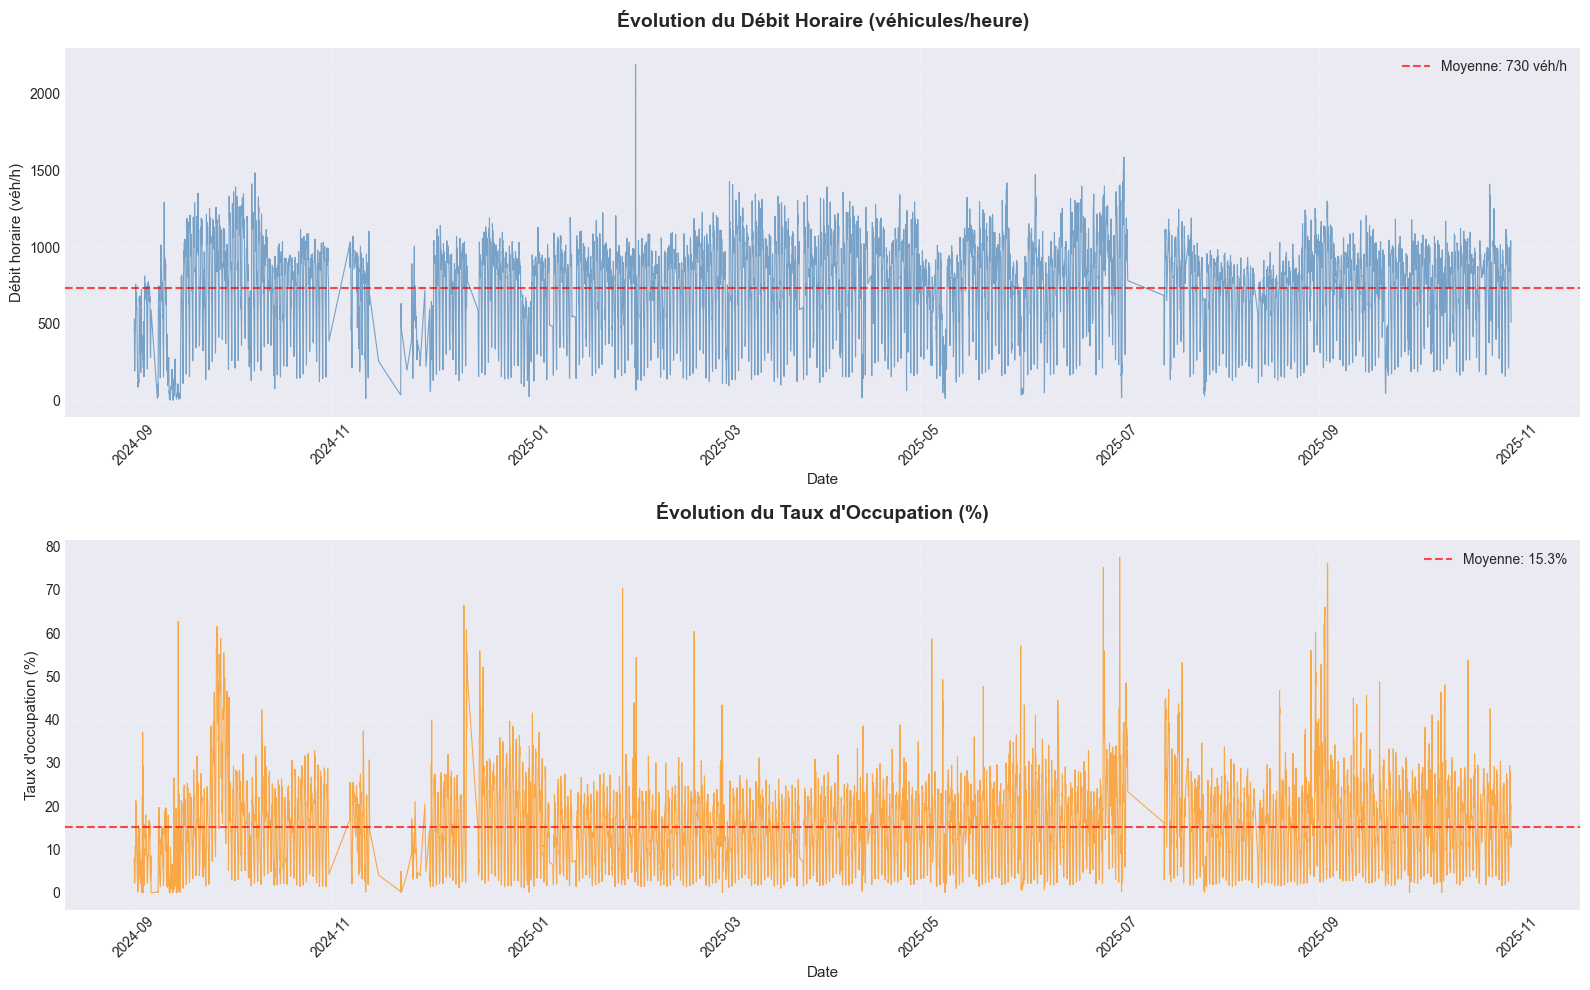

KeyError: 'heure'

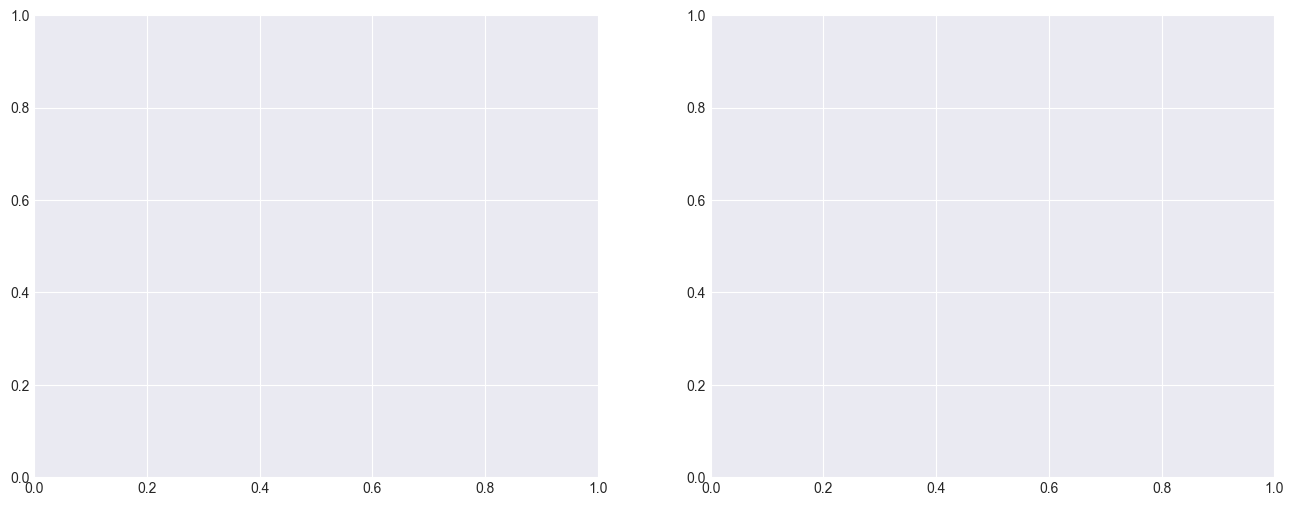

In [336]:
# ============================================================================
# VISUALISATION - DÉBIT HORAIRE ET TAUX D'OCCUPATION
# ============================================================================

print("📊 Création des visualisations...")

# Créer une copie pour la visualisation (sans valeurs manquantes)
df_viz = df_model.dropna(subset=['debit_horaire', 'taux_occupation']).copy()

# Trier par date
df_viz = df_viz.sort_values('date_heure_comptage')

print(f"✅ Données pour visualisation: {len(df_viz)} observations")
print(f"📅 Période: {df_viz['date_heure_comptage'].min()} → {df_viz['date_heure_comptage'].max()}")

# -------------------------
# GRAPHIQUE 1: Évolution temporelle
# -------------------------
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Subplot 1: Débit horaire
axes[0].plot(df_viz['date_heure_comptage'], df_viz['debit_horaire'], 
            color='steelblue', linewidth=0.8, alpha=0.7)
axes[0].set_title('Évolution du Débit Horaire (véhicules/heure)', 
                 fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('Débit horaire (véh/h)', fontsize=11)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].tick_params(axis='x', rotation=45)

# Statistiques sur le graphique
mean_debit = df_viz['debit_horaire'].mean()
axes[0].axhline(y=mean_debit, color='red', linestyle='--', linewidth=1.5, 
               label=f'Moyenne: {mean_debit:.0f} véh/h', alpha=0.7)
axes[0].legend(loc='upper right')

# Subplot 2: Taux d'occupation
axes[1].plot(df_viz['date_heure_comptage'], df_viz['taux_occupation'], 
            color='darkorange', linewidth=0.8, alpha=0.7)
axes[1].set_title('Évolution du Taux d\'Occupation (%)', 
                 fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Taux d\'occupation (%)', fontsize=11)
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].tick_params(axis='x', rotation=45)

# Statistiques sur le graphique
mean_taux = df_viz['taux_occupation'].mean()
axes[1].axhline(y=mean_taux, color='red', linestyle='--', linewidth=1.5, 
               label=f'Moyenne: {mean_taux:.1f}%', alpha=0.7)
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

# -------------------------
# GRAPHIQUE 2: Patterns par heure de la journée
# -------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Débit horaire moyen par heure
debit_par_heure = df_viz.groupby('heure')['debit_horaire'].agg(['mean', 'std'])
axes[0].bar(debit_par_heure.index, debit_par_heure['mean'], 
           color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0].errorbar(debit_par_heure.index, debit_par_heure['mean'], 
                yerr=debit_par_heure['std'], fmt='none', 
                ecolor='black', capsize=3, alpha=0.5)
axes[0].set_title('Débit Horaire Moyen par Heure de la Journée', 
                 fontsize=13, fontweight='bold')
axes[0].set_xlabel('Heure de la journée', fontsize=11)
axes[0].set_ylabel('Débit horaire moyen (véh/h)', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_xticks(range(24))

# Taux d'occupation moyen par heure
taux_par_heure = df_viz.groupby('heure')['taux_occupation'].agg(['mean', 'std'])
axes[1].bar(taux_par_heure.index, taux_par_heure['mean'], 
           color='darkorange', alpha=0.7, edgecolor='black', linewidth=0.5)
axes[1].errorbar(taux_par_heure.index, taux_par_heure['mean'], 
                yerr=taux_par_heure['std'], fmt='none', 
                ecolor='black', capsize=3, alpha=0.5)
axes[1].set_title('Taux d\'Occupation Moyen par Heure de la Journée', 
                 fontsize=13, fontweight='bold')
axes[1].set_xlabel('Heure de la journée', fontsize=11)
axes[1].set_ylabel('Taux d\'occupation moyen (%)', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticks(range(24))

plt.tight_layout()
plt.show()

# -------------------------
# GRAPHIQUE 3: Comparaison Weekend vs Semaine
# -------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Débit horaire - Weekend vs Semaine
for weekend, label, color in [(0, 'Semaine', 'steelblue'), (1, 'Weekend', 'coral')]:
    data_subset = df_viz[df_viz['est_weekend'] == weekend]
    debit_heure = data_subset.groupby('heure')['debit_horaire'].mean()
    axes[0].plot(debit_heure.index, debit_heure.values, 
                marker='o', label=label, color=color, linewidth=2, markersize=6)

axes[0].set_title('Débit Horaire - Semaine vs Weekend', 
                 fontsize=13, fontweight='bold')
axes[0].set_xlabel('Heure de la journée', fontsize=11)
axes[0].set_ylabel('Débit horaire moyen (véh/h)', fontsize=11)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(24))

# Taux d'occupation - Weekend vs Semaine
for weekend, label, color in [(0, 'Semaine', 'steelblue'), (1, 'Weekend', 'coral')]:
    data_subset = df_viz[df_viz['est_weekend'] == weekend]
    taux_heure = data_subset.groupby('heure')['taux_occupation'].mean()
    axes[1].plot(taux_heure.index, taux_heure.values, 
                marker='o', label=label, color=color, linewidth=2, markersize=6)

axes[1].set_title('Taux d\'Occupation - Semaine vs Weekend', 
                 fontsize=13, fontweight='bold')
axes[1].set_xlabel('Heure de la journée', fontsize=11)
axes[1].set_ylabel('Taux d\'occupation moyen (%)', fontsize=11)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(24))

plt.tight_layout()
plt.show()

# -------------------------
# STATISTIQUES DESCRIPTIVES
# -------------------------
print("\n" + "=" * 80)
print("STATISTIQUES DESCRIPTIVES")
print("=" * 80)

print("\n📊 DÉBIT HORAIRE:")
print(df_viz['debit_horaire'].describe())

print("\n📊 TAUX D'OCCUPATION:")
print(df_viz['taux_occupation'].describe())

print("\n📊 CORRÉLATION DÉBIT HORAIRE <-> TAUX D'OCCUPATION:")
correlation = df_viz['debit_horaire'].corr(df_viz['taux_occupation'])
print(f"Coefficient de corrélation de Pearson: {correlation:.4f}")

# Heatmap de corrélation
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
correlation_matrix = df_viz[['debit_horaire', 'taux_occupation']].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
           center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Corrélation entre Débit Horaire et Taux d\'Occupation', 
            fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

print("\n✅ Visualisations terminées!")

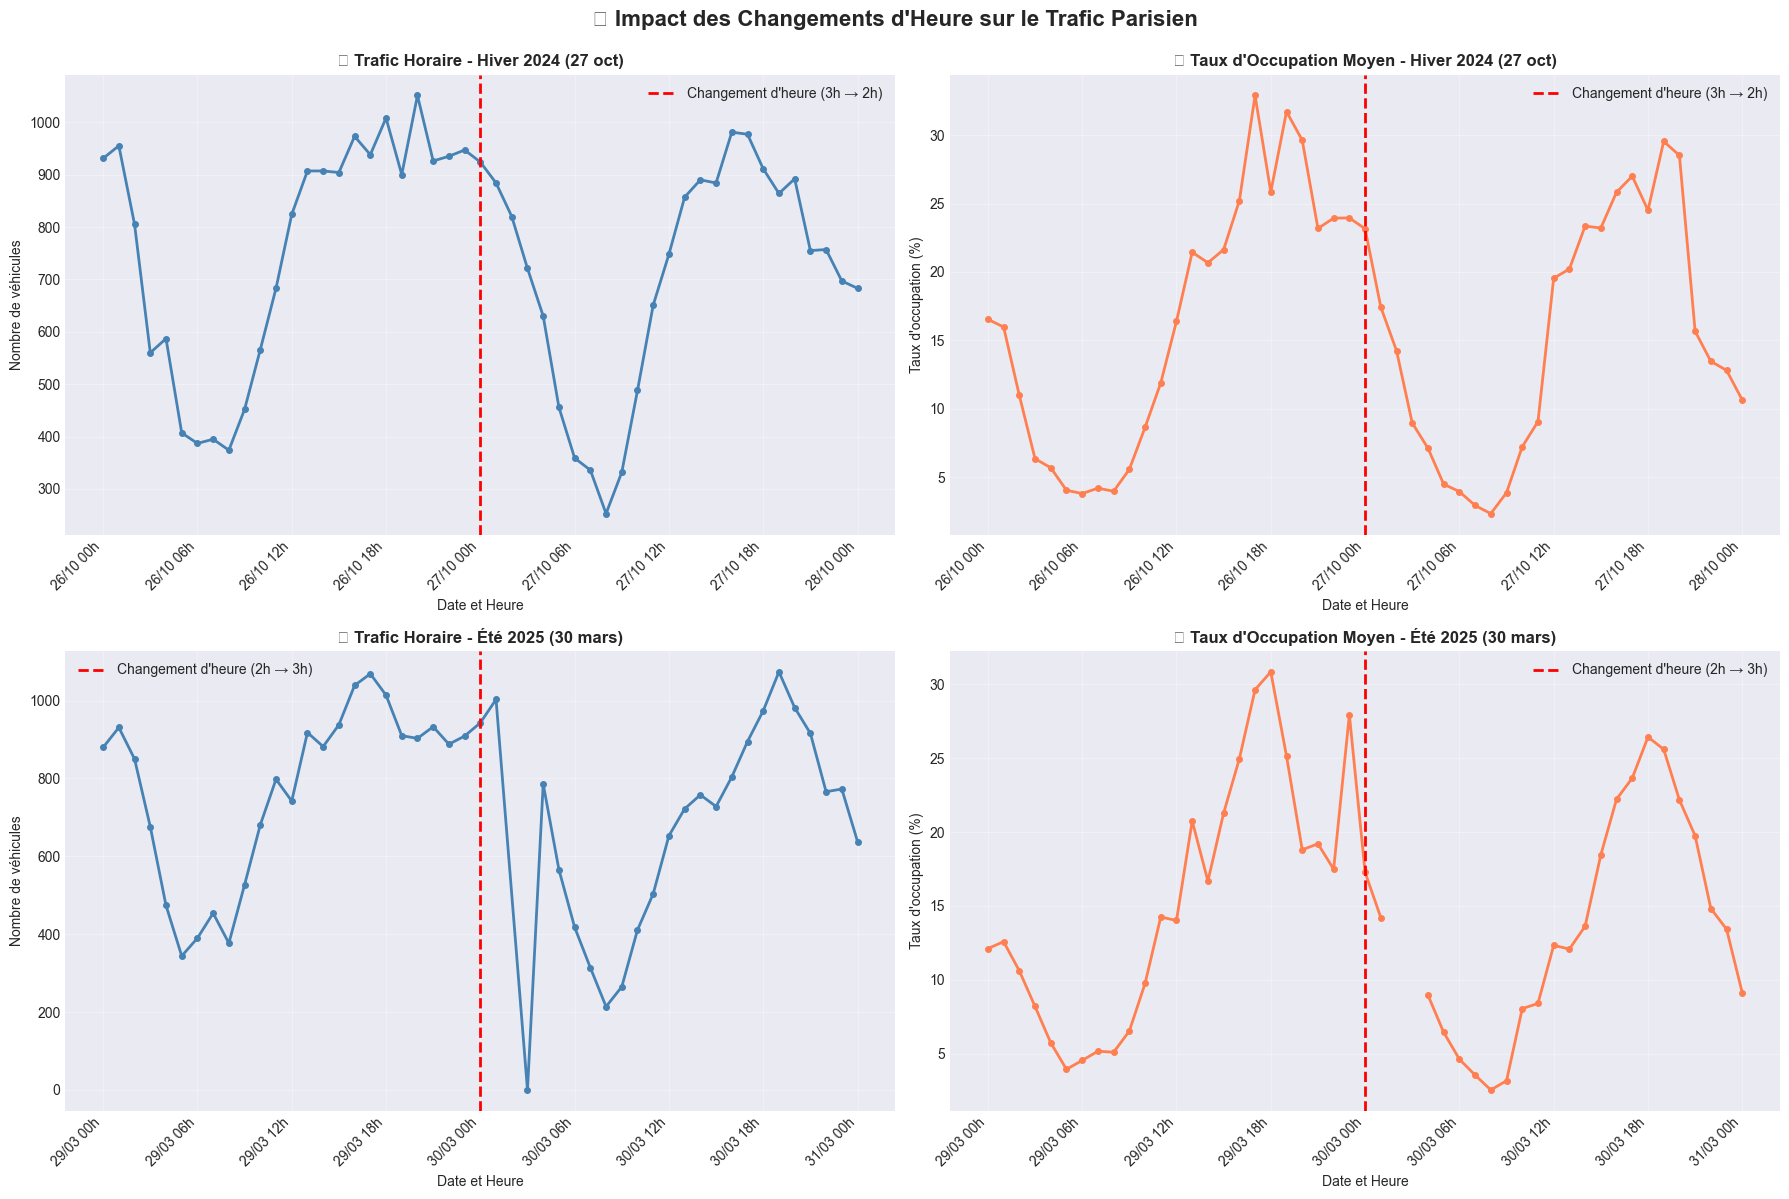


STATISTIQUES DES CHANGEMENTS D'HEURE

📅 Hiver 2024 (27 oct)
   Date du changement: 27/10/2024
   Nombre d'observations: 49
   Trafic moyen: 736 véhicules/h
   Taux d'occupation moyen: 15.8%

📅 Été 2025 (30 mars)
   Date du changement: 30/03/2025
   Nombre d'observations: 48
   Trafic moyen: 737 véhicules/h
   Taux d'occupation moyen: 14.4%


In [337]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ============================================================================
# ANALYSE DES CHANGEMENTS D'HEURE
# ============================================================================

# Dates des changements d'heure
changement_hiver_2024 = pd.Timestamp('2024-10-27')  # Passage à l'heure d'hiver (3h → 2h)
changement_ete_2025 = pd.Timestamp('2025-03-30')     # Passage à l'heure d'été (2h → 3h)

# Filtrer les données autour des changements d'heure (±1 jour)
def get_data_changement_heure(date_changement, nom):
    debut = date_changement - pd.Timedelta(days=1)
    fin = date_changement + pd.Timedelta(days=1)
    
    data = df_model[
        (df_model['date_heure_comptage'] >= debut) & 
        (df_model['date_heure_comptage'] <= fin)
    ].sort_values('date_heure_comptage')
    
    return data, nom

# Récupérer les données
data_hiver, nom_hiver = get_data_changement_heure(changement_hiver_2024, "Hiver 2024 (27 oct)")
data_ete, nom_ete = get_data_changement_heure(changement_ete_2025, "Été 2025 (30 mars)")

# ============================================================================
# VISUALISATION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('📊 Impact des Changements d\'Heure sur le Trafic Parisien', 
             fontsize=16, fontweight='bold', y=0.995)

# -------------------------
# HIVER 2024
# -------------------------

# Trafic horaire - Hiver
ax1 = axes[0, 0]
if len(data_hiver) > 0:
    # Agréger par heure (utiliser debit_horaire au lieu de comptage_horaire)
    trafic_horaire = data_hiver.groupby('date_heure_comptage')['debit_horaire'].sum()
    ax1.plot(trafic_horaire.index, trafic_horaire.values, 
             marker='o', linewidth=2, markersize=4, color='steelblue')
    ax1.axvline(changement_hiver_2024, color='red', linestyle='--', 
                linewidth=2, label='Changement d\'heure (3h → 2h)')
    ax1.set_title(f'🚗 Trafic Horaire - {nom_hiver}', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Date et Heure')
    ax1.set_ylabel('Nombre de véhicules')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %Hh'))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
else:
    ax1.text(0.5, 0.5, 'Pas de données disponibles', 
             ha='center', va='center', transform=ax1.transAxes)

# Taux d'occupation - Hiver
ax2 = axes[0, 1]
if len(data_hiver) > 0:
    # Utiliser taux_occupation au lieu de taux_doccupation
    taux_occupation = data_hiver.groupby('date_heure_comptage')['taux_occupation'].mean()
    ax2.plot(taux_occupation.index, taux_occupation.values, 
             marker='o', linewidth=2, markersize=4, color='coral')
    ax2.axvline(changement_hiver_2024, color='red', linestyle='--', 
                linewidth=2, label='Changement d\'heure (3h → 2h)')
    ax2.set_title(f'📈 Taux d\'Occupation Moyen - {nom_hiver}', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Date et Heure')
    ax2.set_ylabel('Taux d\'occupation (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %Hh'))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
else:
    ax2.text(0.5, 0.5, 'Pas de données disponibles', 
             ha='center', va='center', transform=ax2.transAxes)

# -------------------------
# ÉTÉ 2025
# -------------------------

# Trafic horaire - Été
ax3 = axes[1, 0]
if len(data_ete) > 0:
    trafic_horaire = data_ete.groupby('date_heure_comptage')['debit_horaire'].sum()
    ax3.plot(trafic_horaire.index, trafic_horaire.values, 
             marker='o', linewidth=2, markersize=4, color='steelblue')
    ax3.axvline(changement_ete_2025, color='red', linestyle='--', 
                linewidth=2, label='Changement d\'heure (2h → 3h)')
    ax3.set_title(f'🚗 Trafic Horaire - {nom_ete}', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Date et Heure')
    ax3.set_ylabel('Nombre de véhicules')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %Hh'))
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
else:
    ax3.text(0.5, 0.5, 'Pas de données disponibles', 
             ha='center', va='center', transform=ax3.transAxes)

# Taux d'occupation - Été
ax4 = axes[1, 1]
if len(data_ete) > 0:
    taux_occupation = data_ete.groupby('date_heure_comptage')['taux_occupation'].mean()
    ax4.plot(taux_occupation.index, taux_occupation.values, 
             marker='o', linewidth=2, markersize=4, color='coral')
    ax4.axvline(changement_ete_2025, color='red', linestyle='--', 
                linewidth=2, label='Changement d\'heure (2h → 3h)')
    ax4.set_title(f'📈 Taux d\'Occupation Moyen - {nom_ete}', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Date et Heure')
    ax4.set_ylabel('Taux d\'occupation (%)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %Hh'))
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')
else:
    ax4.text(0.5, 0.5, 'Pas de données disponibles', 
             ha='center', va='center', transform=ax4.transAxes)

plt.tight_layout()
plt.show()

# ============================================================================
# STATISTIQUES
# ============================================================================

print("\n" + "=" * 80)
print("STATISTIQUES DES CHANGEMENTS D'HEURE")
print("=" * 80)

for data, nom, date_changement in [(data_hiver, nom_hiver, changement_hiver_2024), 
                                     (data_ete, nom_ete, changement_ete_2025)]:
    if len(data) > 0:
        print(f"\n📅 {nom}")
        print(f"   Date du changement: {date_changement.strftime('%d/%m/%Y')}")
        print(f"   Nombre d'observations: {len(data)}")
        print(f"   Trafic moyen: {data['debit_horaire'].mean():.0f} véhicules/h")
        print(f"   Taux d'occupation moyen: {data['taux_occupation'].mean():.1f}%")
    else:
        print(f"\n📅 {nom}: Pas de données disponibles")

In [338]:
#Extraction des features temporelles
print("\n🔧 Extraction des features temporelles...")
df_model['heure'] = df_model['date_heure_comptage'].dt.hour
df_model['jour_semaine'] = df_model['date_heure_comptage'].dt.dayofweek  # 0=Lundi, 6=Dimanche
df_model['jour_mois'] = df_model['date_heure_comptage'].dt.day
df_model['mois'] = df_model['date_heure_comptage'].dt.month
df_model['annee'] = df_model['date_heure_comptage'].dt.year
df_model['semaine_annee'] = df_model['date_heure_comptage'].dt.isocalendar().week
df_model['est_weekend'] = (df_model['jour_semaine'] >= 5).astype(int)  # Samedi=5, Dimanche=6

# Features cycliques (pour capturer la nature cyclique du temps)
df_model['heure_sin'] = np.sin(2 * np.pi * df_model['heure'] / 24)
df_model['heure_cos'] = np.cos(2 * np.pi * df_model['heure'] / 24)
df_model['jour_semaine_sin'] = np.sin(2 * np.pi * df_model['jour_semaine'] / 7)
df_model['jour_semaine_cos'] = np.cos(2 * np.pi * df_model['jour_semaine'] / 7)
df_model['mois_sin'] = np.sin(2 * np.pi * df_model['mois'] / 12)
df_model['mois_cos'] = np.cos(2 * np.pi * df_model['mois'] / 12)

print("✅ Features temporelles créées:")
features_temps = ['heure', 'jour_semaine', 'jour_mois', 'mois', 'annee', 'semaine_annee', 
                  'est_weekend', 'heure_sin', 'heure_cos', 'jour_semaine_sin', 
                  'jour_semaine_cos', 'mois_sin', 'mois_cos']
for f in features_temps:
    print(f"  ✓ {f}")

print(f"\n📊 Shape: {df_model.shape}")
print(f"📅 Période des données: {df_model['date_heure_comptage'].min()} → {df_model['date_heure_comptage'].max()}")


🔧 Extraction des features temporelles...
✅ Features temporelles créées:
  ✓ heure
  ✓ jour_semaine
  ✓ jour_mois
  ✓ mois
  ✓ annee
  ✓ semaine_annee
  ✓ est_weekend
  ✓ heure_sin
  ✓ heure_cos
  ✓ jour_semaine_sin
  ✓ jour_semaine_cos
  ✓ mois_sin
  ✓ mois_cos

📊 Shape: (9266, 24)
📅 Période des données: 2024-09-01 05:00:00 → 2025-10-30 00:00:00


In [339]:
df_model.head(10)

,date_heure_comptage,debit_horaire,taux_occupation,etat_trafic,etat_arc,est_vacances,est_ferie,precipitation,duree_precipitation_min,vitesse_vent_ms,date_only,heure,jour_semaine,jour_mois,mois,annee,semaine_annee,est_weekend,heure_sin,heure_cos,jour_semaine_sin,jour_semaine_cos,mois_sin,mois_cos
0,2024-12-09 05:00:00,199.0,2.20945,Fluide,Invalide,0,0,0.0,0.0,6.0,2024-12-09,5,0,9,12,2024,50,0,0.965926,2.588190e-01,0.000000,1.000000,-2.449294e-16,1.000000e+00
1,2024-12-09 06:00:00,235.0,2.28778,Fluide,Invalide,0,0,0.0,4.0,5.5,2024-12-09,6,0,9,12,2024,50,0,1.000000,6.123234e-17,0.000000,1.000000,-2.449294e-16,1.000000e+00
2,2024-12-09 09:00:00,1041.0,11.63222,Fluide,Invalide,0,0,0.0,50.0,5.5,2024-12-09,9,0,9,12,2024,50,0,0.707107,-7.071068e-01,0.000000,1.000000,-2.449294e-16,1.000000e+00
3,2025-09-02 09:00:00,1139.0,28.39222,Pré-saturé,Ouvert,0,0,0.0,0.0,4.3,2025-09-02,9,1,2,9,2025,36,0,0.707107,-7.071068e-01,0.781831,0.623490,-1.000000e+00,-1.836970e-16
4,2024-09-04 20:00:00,686.0,13.21611,Fluide,Invalide,0,0,0.0,0.0,3.5,2024-09-04,20,2,4,9,2024,36,0,-0.866025,5.000000e-01,0.974928,-0.222521,-1.000000e+00,-1.836970e-16
5,2024-09-04 21:00:00,727.0,13.52611,Fluide,Invalide,0,0,0.0,0.0,3.8,2024-09-04,21,2,4,9,2024,36,0,-0.707107,7.071068e-01,0.974928,-0.222521,-1.000000e+00,-1.836970e-16
6,2024-09-04 22:00:00,744.0,13.36722,Fluide,Invalide,0,0,0.0,0.0,2.5,2024-09-04,22,2,4,9,2024,36,0,-0.500000,8.660254e-01,0.974928,-0.222521,-1.000000e+00,-1.836970e-16
7,2025-04-03 11:00:00,1138.0,16.94889,Pré-saturé,Ouvert,0,0,0.0,0.0,4.2,2025-04-03,11,3,3,4,2025,14,0,0.258819,-9.659258e-01,0.433884,-0.900969,8.660254e-01,-5.000000e-01
8,2025-09-03 09:00:00,1299.0,41.56389,Saturé,Ouvert,0,0,0.0,0.0,5.5,2025-09-03,9,2,3,9,2025,36,0,0.707107,-7.071068e-01,0.974928,-0.222521,-1.000000e+00,-1.836970e-16
9,2025-09-03 08:00:00,1051.0,24.45722,Pré-saturé,Ouvert,0,0,0.0,0.0,5.3,2025-09-03,8,2,3,9,2025,36,0,0.866025,-5.000000e-01,0.974928,-0.222521,-1.000000e+00,-1.836970e-16


In [340]:
os.getcwd()
os.makedirs('3.dataset_feature_engineered', exist_ok=True)

In [341]:
df_model.to_csv(
    '3.dataset_feature_engineered/df_model_final.csv',
    index=False,
    sep=';',
)

In [344]:
df_model.groupby('etat_arc').agg({'debit_horaire':['min','max'], 'taux_occupation':['min','max']})

debit_horaire         taux_occupation          
                   min     max             min       max
etat_arc                                                
Barré              0.0  2190.0             0.0  62.71222
Invalide           9.0  1484.0             0.0  70.41167
Ouvert            17.0  1587.0             0.0  77.54556

In [345]:
df_model['debit_horaire'].describe()

count    8703.000000
mean      728.031024
std       295.519534
min         0.000000
25%       514.000000
50%       798.000000
75%       944.000000
max      2190.000000
Name: debit_horaire, dtype: float64

In [350]:
df_model.groupby('jour_semaine').agg({'jour_semaine':'min'})

,jour_semaine
jour_semaine,
0,0
1,1
2,2
3,3
4,4
5,5
6,6


In [378]:
df_model.query('debit_horaire < 10').aggregate({'debit_horaire':'count', 'taux_occupation':['min','max','mean']})

,debit_horaire,taux_occupation
count,16.0,NaN
min,NaN,0.000000
max,NaN,2.893890
mean,NaN,0.332021


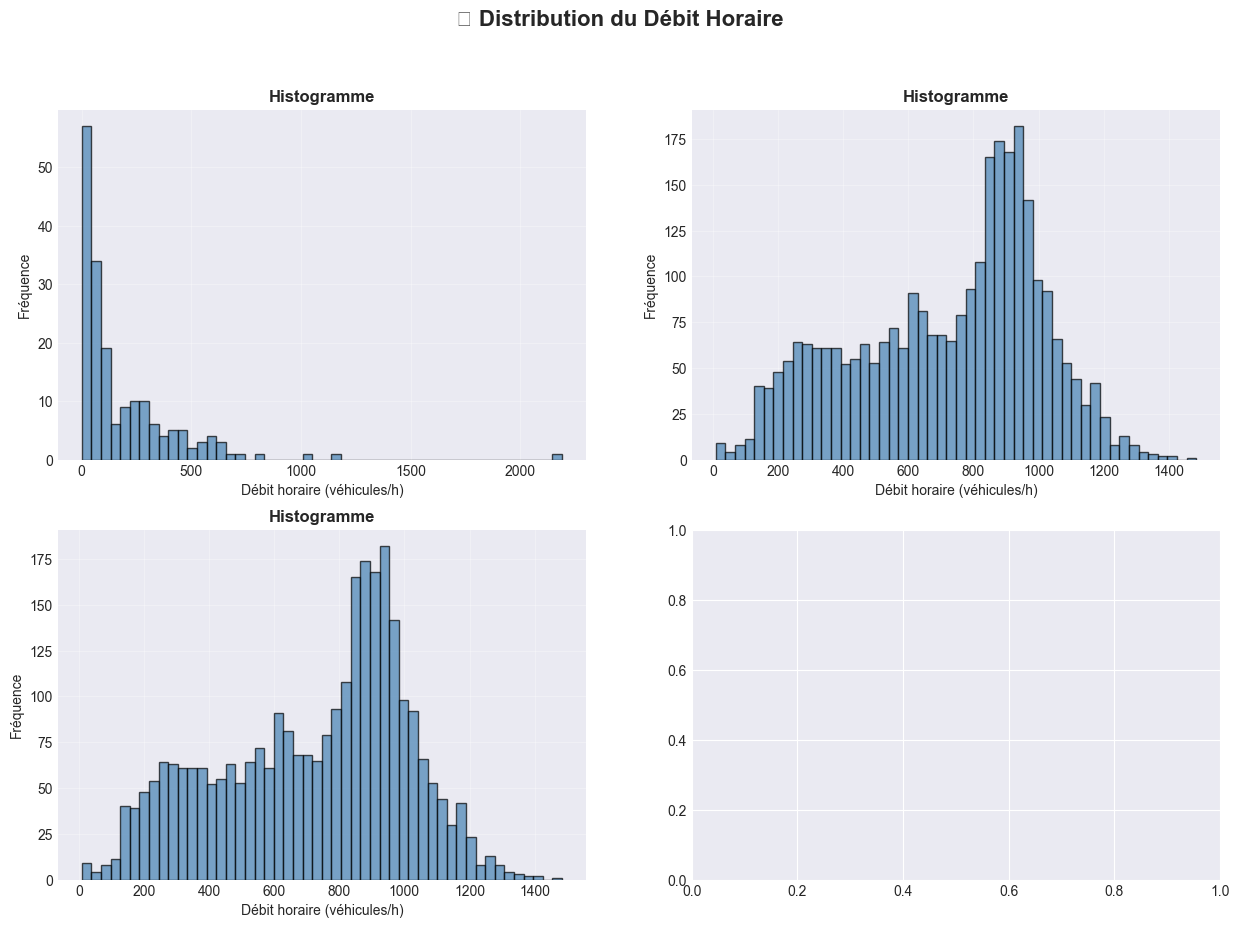

In [372]:
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# VISUALISATION DE LA DISTRIBUTION DU DÉBIT HORAIRE
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('📊 Distribution du Débit Horaire', fontsize=16, fontweight='bold')

# 1. Histogramme
ax1 = axes[0, 0]
ax1.hist(df_model[df_model['etat_arc']=='Barré']['debit_horaire'].dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_title('Histogramme', fontsize=12, fontweight='bold')
ax1.set_xlabel('Débit horaire (véhicules/h)')
ax1.set_ylabel('Fréquence')
ax1.grid(True, alpha=0.3)

ax2 = axes[1, 0]
ax2.hist(df_model[df_model['etat_arc']=='Invalide']['debit_horaire'].dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_title('Histogramme', fontsize=12, fontweight='bold')
ax2.set_xlabel('Débit horaire (véhicules/h)')
ax2.set_ylabel('Fréquence')
ax2.grid(True, alpha=0.3)
ax3 = axes[0, 1]
ax3.hist(df_model[df_model['etat_arc']=='Invalide']['debit_horaire'].dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax3.set_title('Histogramme', fontsize=12, fontweight='bold')
ax3.set_xlabel('Débit horaire (véhicules/h)')
ax3.set_ylabel('Fréquence')
ax3.grid(True, alpha=0.3)